In [1]:
!pip install tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 1.4MB/s 
     |████████████████████████████████| 501kB 46.3MB/s 
     |████████████████████████████████| 3.1MB 47.4MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2019-09-25 09:13:48--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2019-09-25 09:13:48 (6.37 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



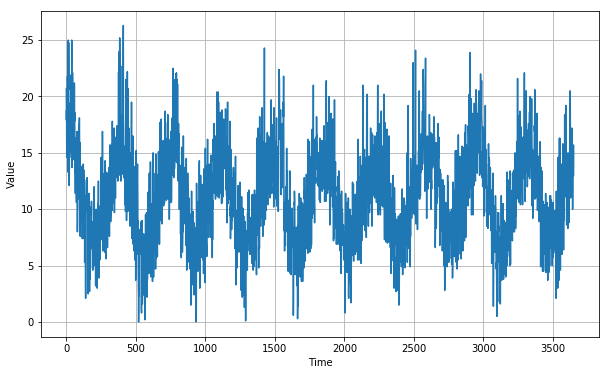

In [5]:
import csv

time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 7s 728ms/step - loss: 31.1593 - mae: 31.6401
Epoch 2/100
10/10 [==============================] - 4s 423ms/step - loss: 30.5752 - mae: 31.0652
Epoch 3/100
10/10 [==============================] - 4s 413ms/step - loss: 29.6785 - mae: 30.1734
Epoch 4/100
10/10 [==============================] - 4s 415ms/step - loss: 28.5556 - mae: 29.0553
Epoch 5/100
10/10 [==============================] - 4s 419ms/step - loss: 27.1878 - mae: 27.6946
Epoch 6/100
10/10 [==============================] - 4s 409ms/step - loss: 25.4788 - mae: 25.9970
Epoch 7/100
10/10 [==============================] - 4s 414ms/step - loss: 23.3038 - mae: 23.8389
Epoch 8/100
10/10 [==============================] - 4s 412ms/step - loss: 20.5453 - mae: 21.1001
Epoch 9/100
10/10 [==============================] - 4s 415ms/step - loss: 17.2259 - mae: 17.7962
Epoch 10/100
10/10 [==============================] - 4s 416ms/step - loss: 13.5191 - mae: 14.0931
Epoch 11/100
10/10 

[1e-08, 0.0001, 0, 60]

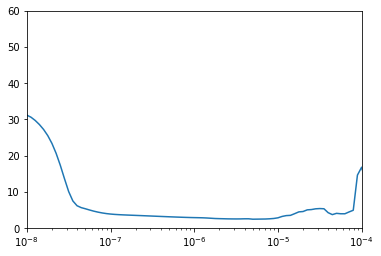

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, 
                             shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 7s 264ms/step - loss: 9.8067 - mae: 10.4597
Epoch 2/150
25/25 [==============================] - 4s 151ms/step - loss: 2.8438 - mae: 3.3216
Epoch 3/150
25/25 [==============================] - 4s 154ms/step - loss: 2.3219 - mae: 2.7798
Epoch 4/150
25/25 [==============================] - 4s 152ms/step - loss: 2.2885 - mae: 2.7465
Epoch 5/150
25/25 [==============================] - 4s 151ms/step - loss: 2.2720 - mae: 2.7297
Epoch 6/150
25/25 [==============================] - 4s 151ms/step - loss: 2.2644 - mae: 2.7219
Epoch 7/150
25/25 [==============================] - 4s 153ms/step - loss: 2.2572 - mae: 2.7146
Epoch 8/150
25/25 [==============================] - 4s 154ms/step - loss: 2.2511 - mae: 2.7083
Epoch 9/150
25/25 [==============================] - 4s 150ms/step - loss: 2.2457 - mae: 2.7029
Epoch 10/150
25/25 [==============================] - 4s 151ms/step - loss: 2.2406 - mae: 2.6977
Epoch 11/150
25/25 [==================

In [0]:
lstm_forecast = model_forecast(model, series[..., np.newaxis], window_size)

lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

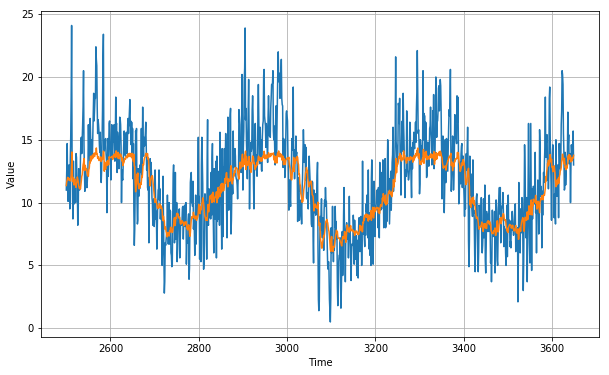

In [14]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

2.0914

In [16]:
print(lstm_forecast)

[11.358818 11.685274 11.800216 ... 13.588836 13.554807 13.765046]
